# Investigate a Dataset: The correlation of vaccination rates and childhood mortality

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-Wrangling" data-toc-modified-id="Data-Wrangling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Wrangling</a></span><ul class="toc-item"><li><span><a href="#General-Properties" data-toc-modified-id="General-Properties-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>General Properties</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Cleaning</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Which-vaccine-(DTP-or-MCV)-is-more-strongly-correlated-with-decrease-in-childhood-mortality?" data-toc-modified-id="Which-vaccine-(DTP-or-MCV)-is-more-strongly-correlated-with-decrease-in-childhood-mortality?-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Which vaccine (DTP or MCV) is more strongly correlated with decrease in childhood mortality?</a></span></li><li><span><a href="#Are-there-any-countries-where-vaccine-prevalence-is-positively-correlated-with-childhood-mortality?" data-toc-modified-id="Are-there-any-countries-where-vaccine-prevalence-is-positively-correlated-with-childhood-mortality?-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Are there any countries where vaccine prevalence is positively correlated with childhood mortality?</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

## Introduction
<a id='intro'></a>

This report analyses the correlation between vaccination rates and childhood mortality. It uses Health data from [Gapminder](https://www.gapminder.org/) as described in the table below.

| File | Description | Retrieved from Gapminder date | Original Source |
| --- | --- | --- | --- |
| dtp3_immunized_percent_of_one_year_olds.csv | Percentage of 1 year old children who have received 3 doses of combined diphtheria, tetanus toxoid and pertussis (DTP) vaccine during the year. | 01-May-2020 | https://data.unicef.org/child-health/immunization.html |
| mcv_immunized_percent_of_one_year_olds.csv | Percentage of 1 year old children who have received at least one dose of measles-containing vaccine (MCV) in a given year. (Some countries for children below 2 years, depending on their policies.) | 01-May-2020 |https://data.unicef.org/topic/child-health/immunization/
| child_mortality_0_5_year_olds_dying_per_1000_born.csv | Deaths of children under 5 years of age per 1000 live births | 01-May-2020 |http://gapm.io/du5mr |

The analysis considers the effect on childhood mortality rate (the dependent variable) in terms of the type of vaccine, the country, and the year (independent variables). It endeavours to answer the following research questions:
1. Which vaccine (DTP or MCV) is more strongly correlated with decrease in childhood mortality?
1. Are there any countries where vaccine prevalence is positively correlated with childhood mortality?

In [1]:
# Import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Ipython Set-up
%matplotlib inline
sns.set()
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML, display
#InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['figure.figsize'] = [15, 5]

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Data Wrangling
<a id='wrangling'></a>

In this chapter, the data is reviewed, roughly cleaned and then filtered to leave only data relevant to the research questions.

### General Properties

Firstly the data is loaded from the csv files.

In [2]:
# Load data 
dtp_raw = pd.read_csv("dtp3_immunized_percent_of_one_year_olds.csv",index_col=0)
dtp_raw.name = "DTP vaccinations [%]"
mcv_raw = pd.read_csv("mcv_immunized_percent_of_one_year_olds.csv",index_col=0)
mcv_raw.name = "MCV vaccinations [%]"
mortality_raw = pd.read_csv("child_mortality_0_5_year_olds_dying_per_1000_born.csv",index_col=0)
mortality_raw.name = "Child mortality [per mil]"

Let's take a quick look at it. Some important characteristics to note:
*  The data files are structured with years in the column and countries in the rows
*  The two vaccination datasets have data for 193 countries, with earliest data in 1980 and latest in 2011
*  The childhood mortality dataset has a much larger time span (1800-2100)
*  All three datasets have multiple missing values filled with a NaN

In [3]:
def _first_look(df):
    """
    display:
        * the number of rows and columns of a DataFrame
        * the total number of missing values
        * the first and last 3 rows 
    """
    df.name = df.name if hasattr(df, "name") else ""
    display(HTML("<b>{name}</b>: {shape[0]} rows, {shape[1]} columns; {nulls} values are missing".format(\
                     name=df.name, shape=df.shape, nulls=df.isnull().sum().sum())))
    with pd.option_context('display.show_dimensions', False):
        display(df.head(3).append(df.tail(3)))

for df in (dtp_raw, mcv_raw, mortality_raw):
    _first_look(df)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4.0,3.0,5.0,5.0,16.0,15.0,11.0,25.0,35.0,33.0,...,36.0,41.0,50.0,58.0,58.0,63.0,64.0,63.0,66.0,66
Albania,94.0,94.0,95.0,95.0,95.0,96.0,96.0,96.0,96.0,94.0,...,98.0,97.0,97.0,98.0,97.0,98.0,99.0,98.0,99.0,99
Algeria,NaN,NaN,NaN,NaN,NaN,69.0,73.0,79.0,85.0,87.0,...,86.0,87.0,86.0,88.0,95.0,95.0,93.0,95.0,95.0,95
Yemen,1.0,3.0,4.0,5.0,7.0,12.0,13.0,18.0,36.0,56.0,...,69.0,66.0,78.0,85.0,85.0,87.0,87.0,86.0,87.0,81
Zambia,NaN,NaN,NaN,49.0,59.0,66.0,66.0,83.0,83.0,83.0,...,84.0,83.0,83.0,82.0,81.0,80.0,87.0,94.0,83.0,81
Zimbabwe,NaN,39.0,46.0,53.0,60.0,63.0,75.0,84.0,85.0,87.0,...,73.0,70.0,68.0,65.0,68.0,72.0,75.0,84.0,94.0,99


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,11.0,NaN,8.0,9.0,14.0,14.0,14.0,31.0,34.0,22.0,...,35.0,39.0,48.0,50.0,53.0,55.0,59.0,60.0,62.0,62
Albania,90.0,90.0,93.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,...,96.0,93.0,96.0,97.0,95.0,97.0,98.0,97.0,99.0,99
Algeria,NaN,NaN,NaN,NaN,NaN,68.0,67.0,73.0,81.0,82.0,...,81.0,84.0,81.0,83.0,91.0,92.0,88.0,92.0,95.0,95
Yemen,2.0,4.0,4.0,6.0,8.0,13.0,15.0,22.0,34.0,48.0,...,64.0,66.0,76.0,76.0,68.0,74.0,73.0,69.0,73.0,71
Zambia,NaN,NaN,NaN,56.0,57.0,58.0,58.0,80.0,80.0,80.0,...,84.0,84.0,85.0,85.0,85.0,93.0,87.0,90.0,96.0,83
Zimbabwe,NaN,56.0,58.0,60.0,62.0,78.0,83.0,88.0,88.0,87.0,...,72.0,70.0,68.0,66.0,67.0,69.0,70.0,76.0,84.0,92


,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,469.0,469.0,469.0,469.0,469.0,469.0,470.0,470.0,470.0,470.0,...,12.60,12.4,12.20,12.00,11.80,11.60,11.50,11.30,11.10,11.10
Albania,375.0,375.0,375.0,375.0,375.0,375.0,375.0,375.0,375.0,375.0,...,2.32,2.3,2.27,2.24,2.22,2.19,2.16,2.14,2.11,2.11
Algeria,460.0,460.0,460.0,460.0,460.0,460.0,460.0,460.0,460.0,460.0,...,4.28,4.2,4.14,4.07,4.00,3.94,3.88,3.82,3.76,3.76
Yemen,540.0,540.0,540.0,540.0,540.0,540.0,540.0,540.0,540.0,540.0,...,14.30,14.1,13.80,13.60,13.40,13.20,13.00,12.80,12.60,12.60
Zambia,410.0,410.0,410.0,410.0,410.0,410.0,410.0,410.0,410.0,410.0,...,12.50,12.3,12.20,12.10,11.90,11.80,11.70,11.60,11.40,11.40
Zimbabwe,396.0,396.0,396.0,396.0,396.0,396.0,396.0,396.0,396.0,396.0,...,14.60,14.5,14.40,14.30,14.20,14.10,13.90,13.80,13.70,13.70


The following initial cleaning will be carried out to make the data easier to work with, and more suitable to the research questions. Section [2.2](#Data-Cleaning) goes into more detail about further pre-processing of the data.
1. Transpose all data so that years are on the rows and countries on the columns. This makes processing data for each country separately easier, which is needed for more in-depth analysis of the differences between countries.
1. Convert the index (years) of all datasets to "int" 
1. Trim the mortality data to align with the vaccination data. Four years longer window (between 1980 and 2015) will be used for the mortality data, since vaccinations are carried out in the first year of life, and the mortality is accumulated up to the fifth year.
1. Convert the child mortality dataset to "percent" (from "per thousand")
1. Trim countries for which more than half of the data is missing (NaN)
1. Trim datasets to use counties which are in all three datasets

In [4]:
#transpose
mcv_trim = mcv_raw.T
dtp_trim = dtp_raw.T
mortality_trim = mortality_raw.T
#convert index to int
mcv_trim.index = dtp_trim.index.astype(int)
dtp_trim.index = dtp_trim.index.astype(int)
mortality_trim.index = mortality_trim.index.astype(int)
#trim mortality_trim
mortality_trim = mortality_trim.loc[1980:2015]
#convert to percent
mortality_trim = mortality_trim / 10
#trim >50% NaNs
mcv_trim.dropna(axis="columns", thresh=len(mcv_trim)//2, inplace=True)
dtp_trim.dropna(axis="columns", thresh=len(dtp_trim)//2, inplace=True)
mortality_trim.dropna(axis="columns", thresh=len(mortality_trim)//2, inplace=True)
#trim countires
countries = sorted(list(set(mcv_trim.columns) & set(dtp_trim.columns) & set(mortality_trim.columns)))
mcv_trim = mcv_trim[countries]
dtp_trim = dtp_trim[countries]
mortality_trim = mortality_trim[countries]
#show cleaned data
#reassign names
mcv_trim.name = mcv_raw.name
dtp_trim.name = dtp_raw.name
mortality_trim.name = "Child mortality_trim [%]"
for df in (dtp_trim, mcv_trim, mortality_trim):
    _first_look(df)

country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
1980,4.0,94.0,NaN,NaN,54.0,44.0,NaN,33.0,90.0,NaN,...,41.0,96.0,53.0,NaN,NaN,56.0,NaN,1.0,NaN,NaN
1981,3.0,94.0,NaN,NaN,79.0,49.0,NaN,40.0,90.0,NaN,...,46.0,96.0,57.0,NaN,NaN,54.0,NaN,3.0,NaN,39.0
1982,5.0,95.0,NaN,NaN,79.0,58.0,NaN,48.0,90.0,NaN,...,53.0,96.0,67.0,NaN,22.0,53.0,NaN,4.0,NaN,46.0
2009,63.0,98.0,95.0,73.0,99.0,87.0,93.0,92.0,83.0,73.0,...,93.0,94.0,95.0,98.0,68.0,84.0,96.0,86.0,94.0,84.0
2010,66.0,99.0,95.0,91.0,98.0,94.0,94.0,92.0,83.0,72.0,...,94.0,94.0,95.0,99.0,68.0,78.0,93.0,87.0,83.0,94.0
2011,66.0,99.0,95.0,86.0,99.0,93.0,95.0,92.0,83.0,74.0,...,95.0,94.0,95.0,99.0,68.0,78.0,95.0,81.0,81.0,99.0


country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
1980,11.0,90.0,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,...,53.0,86.0,50.0,NaN,NaN,50.0,NaN,2.0,NaN,NaN
1981,NaN,90.0,NaN,NaN,NaN,77.0,NaN,NaN,25.0,NaN,...,55.0,97.0,55.0,NaN,NaN,43.0,NaN,4.0,NaN,56.0
1982,8.0,93.0,NaN,NaN,NaN,67.0,NaN,NaN,25.0,NaN,...,58.0,97.0,52.0,NaN,20.0,45.0,1.0,4.0,NaN,58.0
2009,60.0,97.0,92.0,77.0,99.0,99.0,96.0,94.0,76.0,67.0,...,86.0,91.0,94.0,95.0,52.0,87.0,97.0,69.0,90.0,76.0
2010,62.0,99.0,95.0,93.0,98.0,99.0,97.0,94.0,76.0,67.0,...,89.0,90.0,95.0,98.0,52.0,79.0,98.0,73.0,96.0,84.0
2011,62.0,99.0,95.0,88.0,99.0,93.0,97.0,94.0,76.0,67.0,...,90.0,90.0,95.0,99.0,52.0,86.0,96.0,71.0,83.0,92.0


country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
1980,24.40,8.08,14.90,23.80,4.480,4.28,7.29,1.300,1.630,11.10,...,1.410,1.500,3.970,11.70,6.87,4.39,6.82,20.8,15.60,10.70
1981,23.80,7.45,13.40,23.60,4.360,3.94,7.01,1.260,1.550,11.00,...,1.340,1.440,3.580,10.90,6.43,4.20,6.67,19.5,15.70,10.30
1982,23.10,6.86,11.80,23.20,4.240,3.65,6.74,1.220,1.480,10.90,...,1.270,1.390,3.290,10.20,6.00,4.03,6.53,18.4,15.80,9.78
2013,7.70,1.07,2.57,9.84,0.804,1.27,1.59,0.413,0.391,3.04,...,0.464,0.697,0.960,2.98,2.95,1.73,2.23,5.5,7.07,6.23
2014,7.35,1.01,2.53,9.29,0.764,1.21,1.51,0.398,0.380,2.83,...,0.453,0.688,0.924,2.78,2.91,1.73,2.21,5.5,6.69,5.75
2015,7.04,0.96,2.49,8.81,0.729,1.15,1.44,0.387,0.371,2.63,...,0.445,0.680,0.885,2.59,2.86,1.94,2.18,5.5,6.46,5.43


### Data Cleaning

Once the data is roughly aligned, the more detailed exploration can begin.

Firstly, we want to look at how vaccinations and mortality has varied in the available period for all countries. A [box-and-whiskers plot](https://en.wikipedia.org/wiki/Box_plot) can give a quick overview of the variability in each of the datasets. Although a histogram is a better way to visualize the distribution of a single variable, the box-and-whiskers plot can provide most of the information of the histogram in a more compact form, allowing comparisons among countries.

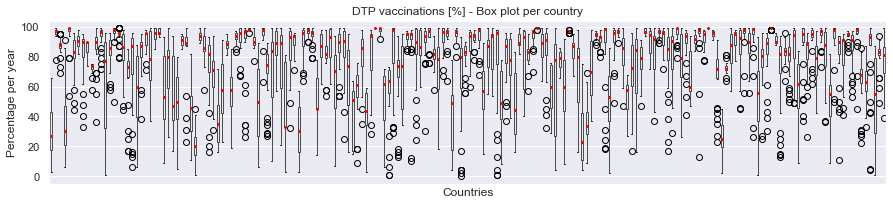

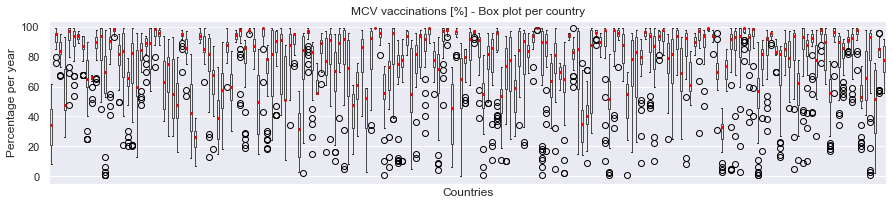

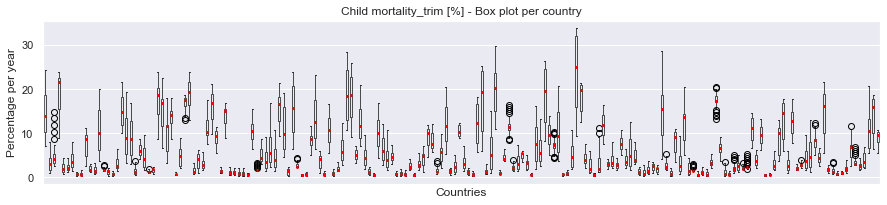

In [5]:
def _quick_boxplot(df):
    """
    Display Box-and-whiskers plot per country
    """
    df.name = df.name if hasattr(df, "name") else ""
    bp = df.boxplot(figsize=(15,3),medianprops = {"linestyle":'--',"linewidth":3, "color":"red"}, return_type='dict')
    [item.set_color('red') for item in bp['medians']] #fixup based on https://stackoverflow.com/questions/35160956/pandas-boxplot-set-color-and-properties-for-box-median-mean
    if len(df.columns) > 100:
        plt.xticks([])
    else:
        plt.xticks(rotation=90)
    plt.title("{} - Box plot per country".format(df.name))
    plt.xlabel("Countries");
    plt.ylabel("Percentage per year");
    plt.show()
for df in (dtp_trim, mcv_trim, mortality_trim):
    _quick_boxplot(df)

From the plots above, it can be observed that the distributions are highly skewed for many of the countries. The vaccinations in each country are generally negatively skewed (the median is closer to the upper boundary). The vaccinations in all countries considered together also appear to be generally negatively skewed (more countries have ranges in the higher percentages), however there is a good spread in the data. The child mortality for all countries is positively skewed (more countries have ranges in the lower percentages).

The histograms (in number of countries) of the median and the [Inter-Quantile Range (IQR)](https://en.wikipedia.org/wiki/Interquartile_range) over the observation period below provide further information about the distribution of the variability among the countries.

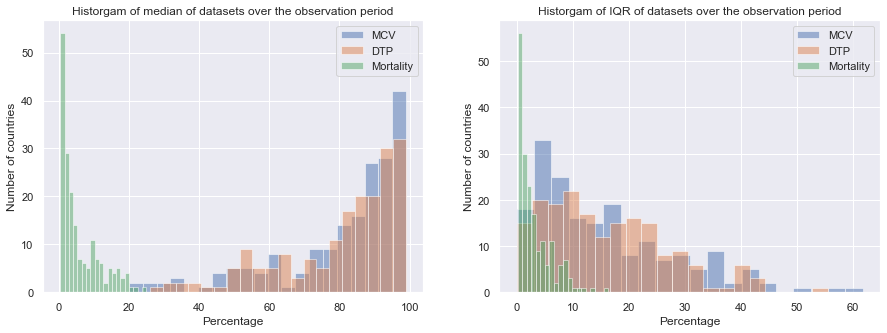

In [6]:
#Create plots
def _subplot_histograms(dfs):
    #one-time wrapper to avoid namespace polution
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for df,title in zip(dfs, ("MCV","DTP","Mortality")):
        df.median().hist(alpha=0.5,label=title,bins=20, ax=ax1);
    ax1.set_title("Historgam of median of datasets over the observation period");
    ax1.set_xlabel("Percentage");
    ax1.set_ylabel("Number of countries");
    ax1.legend()

    for df,title in zip(dfs, ("MCV","DTP","Mortality")):
        (df.quantile(0.75)-df.quantile(0.25)).hist(alpha=0.5,label=title,bins=20,ax=ax2);
    ax2.set_title("Historgam of IQR of datasets over the observation period");
    ax2.set_xlabel("Percentage");
    ax2.set_ylabel("Number of countries");
    ax2.legend();
_subplot_histograms((dtp_trim, mcv_trim, mortality_trim))

Based on these distributions, the data is filtered to select for countries with significant change during the period of interest in any of the variables. Several reasons are listed below:
*  Normalization of the data can to some extent deal with variability among individual countries, however there are many other variables impacting the mortality rate in addition to vaccines. Selecting countries in a transition in vaccine application would result in a stronger contribution of vaccinations to the mortality rate.
*  Many countries have vaccination rates in the high ninety percent, where variability is mostly due to exceptional circumstances rather than a specific trend
*  Since some time is required for the effect of vaccines to be reflected in the data, long-term trends need to be considered rather than small scale effects


The filter selects countries where all of the following conditions are met:
*  Either the median vaccination is lower than the maximum threshold, or median mortality is higher than the minimum threshold
*  Either the MCV or DTP vaccination demonstrates significant change over the period (IQR higher than threshold)
*  The mortality rate demonstrates significant change over the period (IQR higher than threshold)

The thresholds applied are informed by both the histograms above and some trial and error:

In [7]:
#Thresholds
vaccination_max_med = 90.
mortality_min_med = 5.
vaccination_min_IQR = 15.
mortality_min_IQR = 3.

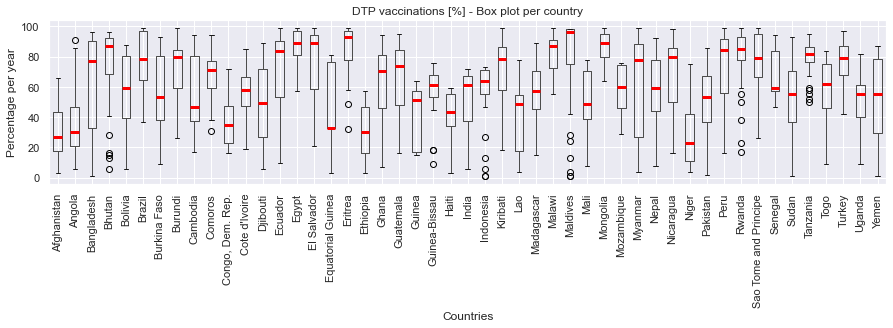

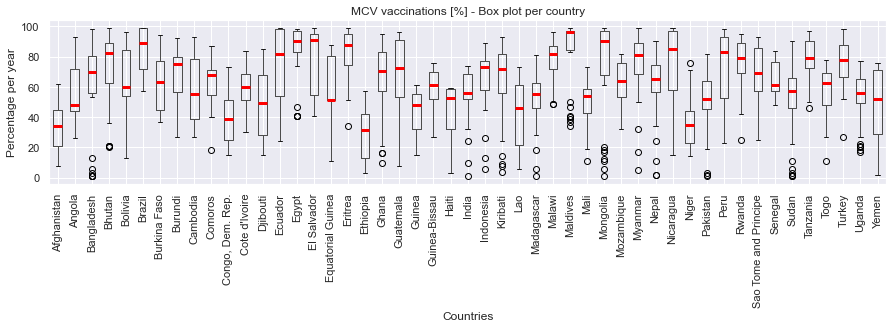

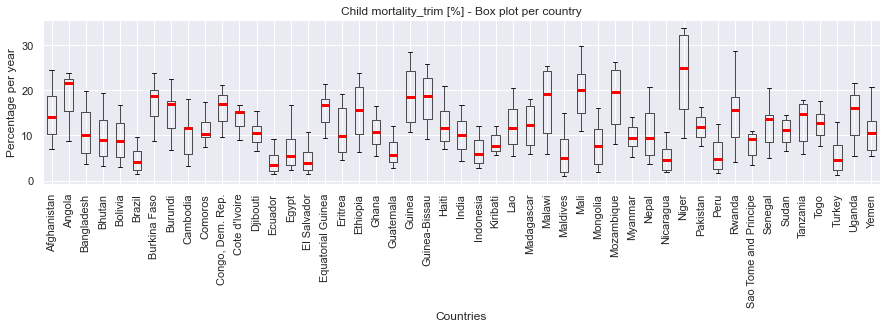

In [8]:
#Apply thresholds to individual datasets
mcv_max_med_bool = mcv_trim.median() < vaccination_max_med
dtp_max_med_bool = dtp_trim.median() < vaccination_max_med
mor_min_med_bool = mortality_trim.median() > mortality_min_med
mcv_min_IQR_bool = mcv_trim.quantile(.75) - mcv_trim.quantile(.25) > vaccination_min_IQR
dtp_min_IQR_bool = dtp_trim.quantile(.75) - dtp_trim.quantile(.25) > vaccination_min_IQR
mor_min_IQR_bool = mortality_trim.quantile(.75) - mortality_trim.quantile(.25) > mortality_min_IQR

#Apply filters
filter_bool = (mcv_max_med_bool | dtp_max_med_bool | mor_min_med_bool) \
                & (mcv_min_IQR_bool | dtp_min_IQR_bool) \
                & mor_min_IQR_bool

#Create filtered datasets
dtp_filt = dtp_trim[dtp_trim.columns[filter_bool]]
mcv_filt = mcv_trim[mcv_trim.columns[filter_bool]]
mortality_filt = mortality_trim[mortality_trim.columns[filter_bool]]

#Plot
for df,name in zip((dtp_filt, mcv_filt, mortality_filt),(dtp_trim.name, mcv_trim.name, mortality_trim.name)):
    df.name = name
    _quick_boxplot(df)

The plots above demonstrate good variability of the datasets.

## Exploratory Data Analysis
<a id='eda'></a>


This chapter explores the data in detail aiming to shed light on the research questions:
1. Which vaccine (DTP or MCV) is more strongly correlated with decrease in childhood mortality?
1. Are there any countries where vaccine prevalence is positively correlated with childhood mortality?

Before detailed review of each of the questions, some transformations applicable to both questions are applied. 

Firstly, a rolling average is applied to the mortality data. This is useful to align the effect of a vaccination in a particular year, with the effect on mortality. Since the vaccination happens during the first year of a child's life, and the mortality data considers the first five years, a left-aligned window of length five is chosen. 

In [9]:
mortality_avg = mortality_filt.rolling(window=5).mean().shift(-4)[:-4]

Secondly, the cleaned and filtered data can be further standardized to make comparison between countries more robust. The standardization technique used assumes normally distributed sample and represents each value in terms of the number of standard deviations from the mean, with 0 centered at the mean, +1 being one standard deviation larger than the mean, and vice versa -1 being one standard deviation lower. This standardization comes especially useful in the process of calculating the correlation.

In [10]:
def standardize(df):
    """
    Standardize a dataframe by columns: 
    Convert each value in the column to the number of standard deviations it is above or below the mean of that column
    """
    return (df - df.mean())/df.std()

In [11]:
dtp_std = standardize(dtp_filt);
mcv_std = standardize(mcv_filt);
mortality_std = standardize(mortality_avg);

### Which vaccine (DTP or MCV) is more strongly correlated with decrease in childhood mortality?

A simple way to calculate the whether DTP or MCV has stronger correlation is to compute the [Pearson Correlation Coefficient (PCC)](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the vaccination rate and the mortality rate.

In [12]:
def PCC(df1, df2):
    """
    Compute the Pearson Correlation Coefficient between each column of df1 and df2
    Requires both rows and columns of df1 and df2 to be aligned
    Requires that the datasets are in standard format (present in number of standard deviation from the mean)
    """
    assert(df1.size==df2.size)
    return (df1*df2).mean()

Simply looking at the median correlation for all countries makes it apparent that both are strongly negatively correlated (i.e. higher vaccination is correlated with lower mortality). DTP is slightly more strongly negatively correlated. The median is chosen as a measure instead of the the mean, since, as it will be demonstrated later, some outliers are present which makes the median more representative of the data set.

In [13]:
dtp_correl = PCC(dtp_std,mortality_std)
mcv_correl = PCC(mcv_std,mortality_std)
print("""PCC of DTP: {:.2f}\nPCC of MCV: {:.2f}""".format(dtp_correl.median(), mcv_correl.median()))

PCC of DTP: -0.84
PCC of MCV: -0.77


The trend is persistent if we look across all countries as well. It can easily be observed that DTP generally has stronger negative correlation with the mortality rates.

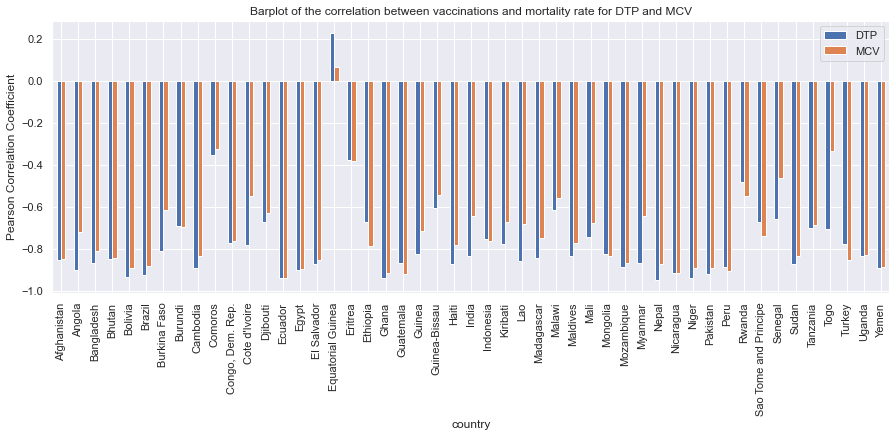

In [14]:
pd.DataFrame({"DTP":dtp_correl, "MCV":mcv_correl}).plot(kind="bar")
plt.legend();
plt.xticks(rotation=90);
plt.ylabel("Pearson Correlation Coefficient")
plt.title("Barplot of the correlation between vaccinations and mortality rate for DTP and MCV");

### Are there any countries where vaccine prevalence is positively correlated with childhood mortality?

Although the correlation coefficients have averages of -0.77 and -0.84 for MCV and DTP respectively, an outlier emerges in the data from Equatorial Guinea, which has a small positive correlation between vaccinations and mortality. 

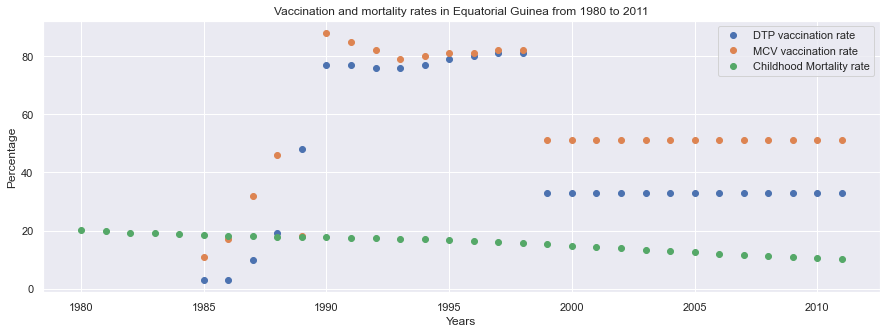

In [15]:
dtp_filt["Equatorial Guinea"].plot(label="DTP vaccination rate", marker="o", linestyle='None')
mcv_filt["Equatorial Guinea"].plot(label="MCV vaccination rate", marker="o", linestyle='None')
mortality_avg["Equatorial Guinea"].plot(label="Childhood Mortality rate", marker="o", linestyle='None')
plt.legend()
plt.xlabel("Years")
plt.ylabel("Percentage")
plt.title("Vaccination and mortality rates in Equatorial Guinea from 1980 to 2011");

In Equatorial Guinea, an initial rise in vaccination rate is observed followed by a decrease in 1999. On the other hand, the child mortality rate is monotonously decreasing. This leads to the small values for the correlation coefficient.

<a id='conclusions'></a>
## Conclusions

In this analysis of the correlation between vaccination rates and childhood mortality, it is determined that both the  measles-containing vaccine (MCV) and the combined diphtheria, tetanus toxoid and pertussis (DTP) vaccine are strongly negatively correlated with a the childhood mortality rate (Pearson Correlation Coefficient of -0.77 and -0.84, respectively). This means that countries which have increased rates of vaccinations also have decreased rates of childhood mortality over the observation period from 1980 to 2011. The analysis cannot conclude whether the vaccination and mortality rates are causally related, and the observed correlation might be caused by hidden variables which have not been corrected for in this analysis.

The analysis also found that the DTP vaccine has a stronger correlation with decrease in the mortality than the MCV vaccine. Again, no causal inference can be made based on the evaluation.

Finally, an interesting outlier from the general trend was detected. The apparent positive correlation between vaccination rates and childhood mortality rate in Equatorial Guinea is a good example of the limitations of the techniques applied in this report.

Future work should aim to use more sensitive techniques which would allow the including of data from co where vaccine usage and mortality rate do not change significantly. Statistical inference tests should also be applied to validate that the results are not a consequence of random chance.